In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import ast

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif', size=11)

In [2]:
results = pd.read_csv('../src/results.csv', index_col=[0])
results.error_trace = results.error_trace.map(lambda x: ast.literal_eval(x))
results.head()

,algo,rho,epochs,batch_size,latent_dim,hidden_dims,ker_str_pad,error_trace,duration
0,adam,0.01,2,10,2,"[4, 8, 16]","[(10, 3, 1), (8, 2, 0), (3, 3, 0)]","[0.3656269609928131, 0.343485951423645, 0.3072...",62.003432


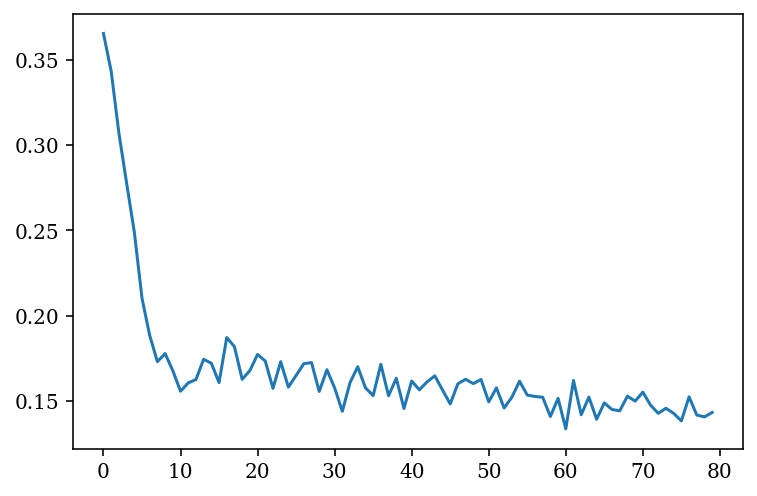

In [3]:
for i, row in results.iterrows():
    plt.plot(row.error_trace)

In [4]:
latent = pd.read_csv('../src/latent_vectors.csv', index_col=[0])
latent.latent_vector = latent.latent_vector.map(lambda x: ast.literal_eval(x))
latent.head()

,latent_vector
0,"[0.72801304, 2.1761956]"
1,"[-1.5037138, 0.14124967]"
2,"[-1.1649458, 0.004941866]"
3,"[-1.1993754, 0.10439953]"
4,"[1.1572688, 1.291594]"


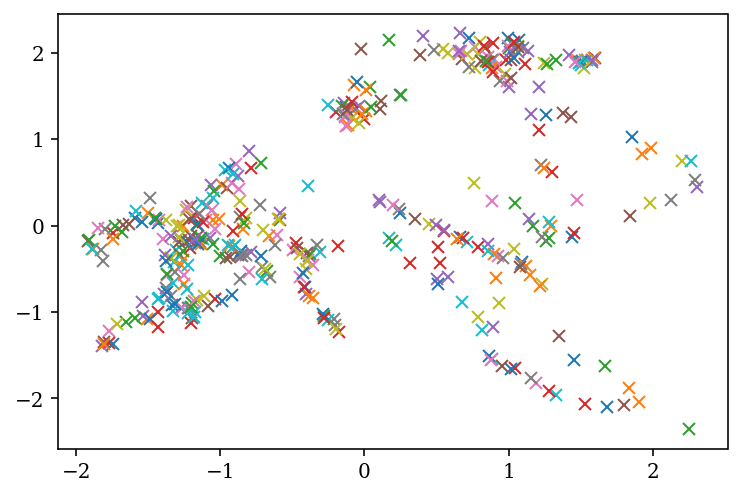

In [5]:
for i, row in latent.iterrows():
    plt.plot(row.latent_vector[0], row.latent_vector[1], 'x')